# 0.0 IMPORTS

In [52]:
import re
import warnings
import sweetviz
import IPython
import pickle

import pandas            as pd
import numpy             as np
import lightgbm          as lgb
import xgboost           as xgb
import seaborn           as sns

from category_encoders       import TargetEncoder
from sklearn.preprocessing   import OneHotEncoder
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import GaussianNB
from scipy                   import stats
from unidecode               import unidecode
from catboost                import CatBoostClassifier
from skopt                   import gp_minimize
from sklearn.model_selection import cross_val_score, KFold
from imblearn                import over_sampling
from sklearn                 import svm


from sklearn                 import model_selection   as ms
from sklearn                 import metrics           as m
from matplotlib              import pyplot            as plt
from imblearn                import combine           as c

## 0.1 AUX FUNCTIONS

In [53]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

def ml_error( model_name, ytest, yhat ):
    f1 = m.f1_score( ytest, yhat )

    return pd.DataFrame( {'Model name': model_name,
                          'F1': f1 }, index=[0] )

## 0.2 READ DATASETS

In [54]:
df = pd.read_csv('datasets/train.csv')

# 1.0 DATA DESCRIPTION

## 1.1 Shape

In [55]:
print( f"df users rows: {df.shape[0]}" )
print( f"df users columns: {df.shape[1]}" )

df users rows: 9500
df users columns: 17


## 1.2 Check NA

## 1.3 Data Types

### 1.3.1 Change Dtypes

## 1.4 Check Balance

In [56]:
df['limite_adicional'].value_counts()

Negar       7995
Conceder    1505
Name: limite_adicional, dtype: int64

# 2.0 FEATURE ENGINEERING

In [57]:
df2 = df.copy()

# 3.0 DATA FILTERING

In [58]:
df3 = df2.copy()

df3['idade'] = df3['idade'].apply( lambda x: int(str(x)[:2]) if x>100 else x )
df3['taxa_juros'] = df3['taxa_juros'].apply( lambda x: int(str(x)[:2]) if x>100 else x )

mediana_cartao = df3['num_cartoes_credito'].median()
df3['num_cartoes_credito'] = df3['num_cartoes_credito'].apply( lambda x: mediana_cartao if x>100 else x )

# 4.0 EDA

In [59]:
df4 = df3.copy()

# sweetviz report
# report = sweetviz.analyze( df, "limite_adicional" )
# report.show_html()

# 5.0 DATA PREPARATION

In [60]:
df5 = df3.copy()

In [61]:
# limite adicional
df5['limite_adicional'] = df5['limite_adicional'].apply( lambda x: 0 if x == 'Negar' else 1 )

# target encoder
te = TargetEncoder()

df5['investe_exterior'] = te.fit_transform( df5['investe_exterior'], df5['limite_adicional'] )
pickle.dump( te, open( 'encoders/investe_exterior_encoding', 'wb' ) )

df5['pessoa_polit_exp'] = te.fit_transform( df5['pessoa_polit_exp'], df5['limite_adicional'] )
pickle.dump( te, open( 'encoders/pessoa_polit_exp_encoding', 'wb' ) )

# Resample Dataset

In [62]:
df_features = df5.drop( columns='limite_adicional')
df_target = df5['limite_adicional'].copy()

# # define
# os = over_sampling.SMOTE( random_state=32, n_jobs=-1 )

# # apply
# features_smt, target_smt = os.fit_resample( df_features, df_target )

In [63]:
# define
smt = c.SMOTETomek( random_state=32, n_jobs=-1 )

# apply
features_smt, target_smt = smt.fit_resample( df_features, df_target )

# 6.0 FEATURE SELECTION

In [64]:
# model
forest = ExtraTreesClassifier( n_jobs=-1 )

# training
X = df5.drop( columns=['limite_adicional'])
Y = df5['limite_adicional'].values

x_train_fselection, x_val, y_train_fselection, y_val = ms.train_test_split( X, Y, test_size=0.5, random_state=42 )

forest.fit( x_train_fselection, y_train_fselection )

ExtraTreesClassifier(n_jobs=-1)

Feature Ranking:

                   feature  importance
0      dias_atraso_dt_venc    0.127808
0               taxa_juros    0.122630
0      num_cartoes_credito    0.109910
0             divida_atual    0.072606
0      num_pgtos_atrasados    0.068011
0              saldo_atual    0.064287
0     num_contas_bancarias    0.062572
0                    idade    0.053675
0    num_consultas_credito    0.053093
0              renda_anual    0.052596
0               id_cliente    0.051919
0   valor_em_investimentos    0.050852
0  taxa_utilizacao_credito    0.050443
0          num_emprestimos    0.043559
0     investe_exterior_Sim    0.004931
0     investe_exterior_Não    0.004369
0     pessoa_polit_exp_Sim    0.003432
0     pessoa_polit_exp_Não    0.003306


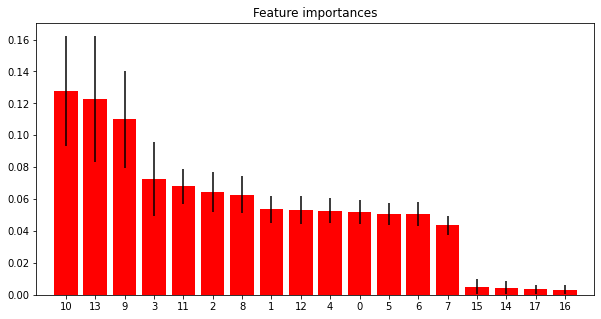

In [65]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[::-1]

# print the feature ranking
df = pd.DataFrame()

print( 'Feature Ranking:\n' )
for i, j in zip( x_train_fselection,forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) ) 

# plot the impurity-based feature importances of the forest
plt.figure(figsize=(10,5))
plt.title( 'Feature importances' )
plt.bar( range( x_train_fselection.shape[1] ), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_fselection.shape[1]), indices )
plt.xlim( [-1, x_train_fselection.shape[1]] )
plt.show()

# 7.0 MACHINE LEARNING

In [66]:
X = features_smt.drop( columns = ['id_cliente'] )
Y = target_smt.copy()
# X = df5.drop(columns=['limite_adicional','id_cliente'])
# Y = df5['limite_adicional'].copy()

X_train, X_val, y_train, y_val = ms.train_test_split( X, Y, test_size=0.2, random_state=42 )

## 7.1 LightGBM

In [67]:
# model
model_lgb = lgb.LGBMClassifier( n_jobs=-1 ).fit( X_train, y_train )
pickle.dump( model_lgb, open( 'model/model_lgb.pkl', 'wb' ) )

# prediction
yhat_lgb = model_lgb.predict( X_val )

# performance
model_lgb_results = ml_error( 'LightGBM',  y_val, yhat_lgb )
model_lgb_results

,Model name,F1
0,LightGBM,0.919643


### 7.1.1 Cross Validation

In [68]:
# # cross validation
# kfold = KFold(n_splits=5, random_state=1, shuffle=True)
# cv = cross_val_score(model_lgb, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
# print( "{} +/- {}".format( np.mean(cv), np.std(cv)) )

## 7.2 XGBoost

In [69]:
# model
model_xgb = xgb.XGBClassifier( n_jobs=-1 ).fit( X_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( X_val )

# performance
model_xgb_results = ml_error( 'XGBoost',  y_val, yhat_xgb )
model_xgb_results

,Model name,F1
0,XGBoost,0.916799


### 7.2.1 Cross Validation

In [70]:
# # cross validation
# kfold = KFold(n_splits=5, random_state=1, shuffle=True)
# cv = cross_val_score(model_xgb, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
# print( "{} +/- {}".format( np.mean(cv), np.std(cv)) )

## 7.3 CatBoost

In [71]:
# model
model_cb = CatBoostClassifier( verbose=False ).fit( X_train, y_train )

# prediction
yhat_cb = model_cb.predict( X_val )

# performance
model_cb_results = ml_error( 'CatBoost',  y_val, yhat_cb)
model_cb_results

,Model name,F1
0,CatBoost,0.919629


### 7.3.1 Cross Validation

## 7.4 Random Forest Classifier

In [72]:
# model
model_rf = RandomForestClassifier().fit( X_train, y_train )

# prediction
yhat_rf = model_rf.predict( X_val )

# performance
model_rf_results = ml_error( 'CatBoost',  y_val, yhat_rf)
model_rf_results

,Model name,F1
0,CatBoost,0.921397


## 7.5 Extra Trees Classifier

In [73]:
# model
model_et = ExtraTreesClassifier().fit( X_train, y_train )

# prediction
yhat_et = model_et.predict( X_val )

# performance
model_et_results = ml_error( 'CatBoost',  y_val, yhat_et)
model_et_results

,Model name,F1
0,CatBoost,0.927797


## 7.6 KNN

In [74]:
# model
model_knn = KNeighborsClassifier().fit( X_train, y_train )

# prediction
yhat_knn = model_knn.predict( X_val )

# performance
model_knn_results = ml_error( 'KNN',  y_val, yhat_knn)
model_knn_results

,Model name,F1
0,KNN,0.796156


# 7.7 Logistic Regression

In [75]:
# model
model_logistic = LogisticRegression().fit( X_train, y_train )

# prediction
yhat_logistic = model_logistic.predict( X_val )

# performance
model_logistic_results = ml_error( 'Logistic',  y_val, yhat_logistic)
model_logistic_results

,Model name,F1
0,Logistic,0.692622


## 7.8 Naive Bayes

In [76]:
# model
model_gaussian = GaussianNB().fit( X_train, y_train )

# prediction
yhat_gaussian = model_gaussian.predict( X_val )

# performance
model_gaussian_results = ml_error( 'Logistic',  y_val, yhat_gaussian )
model_gaussian_results

,Model name,F1
0,Logistic,0.762262


## 7.9 SVM

In [77]:
# model
model_svm = svm.SVC().fit( X_train, y_train )

# prediction
yhat_svm = model_svm.predict( X_val )

# performance
model_svm_results = ml_error( 'Logistic',  y_val, yhat_svm )
model_svm_results

,Model name,F1
0,Logistic,0.546617


## 7.10 Stacking Classifier

In [78]:
estimators_list = [ ('lgbm', model_lgb), ('xgboost', model_xgb), ('catboost', model_cb), ('random forest', model_rf ), ('extra trees', model_et),
('knn', model_knn), ('logistic regression', model_logistic), ('gaussian', model_gaussian), ('svm', model_svm) ]

# Build stack model
stack_model = StackingClassifier( estimators = estimators_list, n_jobs=-1, verbose=True ).fit( X_train, y_train )
# pickle.dump( stack_model, open( 'model/model_stack.pkl', 'wb' ) )

# prediction
yhat_stack = stack_model.predict( X_val )

# performance
stack_model_results = ml_error( 'Stacking', y_val, yhat_stack )
stack_model_results

,Model name,F1
0,Stacking,0.930794


### 7.7.1 Cross Validation

In [79]:
# # cross validation
# kfold = KFold(n_splits=5, random_state=1, shuffle=True)
# cv = cross_val_score(stack_model, X, Y, scoring='f1', cv=kfold, n_jobs=-1, error_score='raise' )
# print( "{} +/- {}".format( np.mean(cv), np.std(cv)) )

# 8.0 Bayesian Optimization

## 8.1 LGBM

### 8.1.1 Normal

In [80]:
# search_space = [(100, 1500), #name = 'n_estimators'), 
#                 (1, 20), #name = 'max_depth'), 
#                 (0.001, 0.1, 'log-uniform'),#, name = 'learning_rate'),
#                 (2, 128), #name = 'num_leaves'),
#                 (1, 100), #name = 'min_child_samples'),
#                 (0.05, 1.0), #name = 'subsample'),
#                 (0.15, 1.0) #name = 'colsample_bytree')]
# ]

# def treinar_modelo( params ):
#     n_estimators = params[0]
#     max_depth = params[1]
#     learning_rate = params[2]
#     num_leaves = params[3]
#     min_child_samples = params[4]
#     subsample = params[5]
#     colsample_bytree = params[6]

#     print(params)

#     lgbm_model = lgb.LGBMClassifier( learning_rate = learning_rate, num_leaves=num_leaves, n_estimators=n_estimators, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42, subsample_freq=1)
#     lgbm_model.fit( X_train, y_train )

#     yhat_lgb = lgbm_model.predict( X_val )

#     return -m.f1_score( y_val, yhat_lgb )

# result = gp_minimize( treinar_modelo, search_space, n_calls = 200, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )
# print('\n')

### 8.1.2 Cross Validation

In [81]:
# LGBM CV BAYESIAN SEARCH

# search_space = [(100, 1500), #name = 'n_estimators'), 
#                 (1, 20), #name = 'max_depth'), 
#                 (0.001, 0.1, 'log-uniform'),#, name = 'learning_rate'),
#                 (2, 128), #name = 'num_leaves'),
#                 (1, 100), #name = 'min_child_samples'),
#                 (0.05, 1.0), #name = 'subsample'),
#                 (0.15, 1.0) #name = 'colsample_bytree')]
# ]

# def treinar_modelo( params ):
#     n_estimators = params[0]
#     max_depth = params[1]
#     learning_rate = params[2]
#     num_leaves = params[3]
#     min_child_samples = params[4]
#     subsample = params[5]
#     colsample_bytree = params[6]

#     print(params, '\n' )

#     lgbm_model = lgb.LGBMClassifier( learning_rate = learning_rate, num_leaves=num_leaves, n_estimators=n_estimators, max_depth=max_depth, min_child_samples=min_child_samples, subsample=subsample, colsample_bytree=colsample_bytree, n_jobs=-1, random_state=42, subsample_freq=1)
#     kfold = KFold(n_splits=5, random_state=1, shuffle=True)
#     cv = cross_val_score(lgbm_model, X, Y, scoring='f1', cv=kfold, n_jobs=-1)

#     return -np.mean(cv)

# result = gp_minimize( treinar_modelo, search_space, n_calls = 200, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )

## 8.2 CatBoost

### 8.2.1 Normal

In [82]:
# search_space = [(6, 10), #depth
#                 (0.01, 0.1), #learning rate
#                 (100, 200), #iterations
# ]

# def treinar_modelo( params ):
#     depth = params[0]
#     learning_rate = params[1]
#     iterations = params[2]

#     print(params, '\n' )

#     catboost_model = CatBoostClassifier( depth = depth, learning_rate=learning_rate, iterations=iterations, verbose=False )
#     catboost_model.fit( X_train, y_train )

#     yhat_catboost = catboost_model.predict( X_val )

#     return -m.f1_score( y_val, yhat_catboost )

# result = gp_minimize( treinar_modelo, search_space, n_calls = 100, n_initial_points = 10, verbose=True, n_jobs=-1, random_state= 42 )